In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import shutil

In [2]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
cat_source = r'C:\Users\ANUBHAV\OneDrive\Pictures\train\cats'
dog_source = r'C:\Users\ANUBHAV\OneDrive\Pictures\train\dogs'  
output_dir = 'PetImages_cleaned'
model_save_dir = 'trained_model'

In [4]:
os.makedirs(output_dir, exist_ok=True)
for class_name in ['Cat', 'Dog']:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)
os.makedirs(model_save_dir, exist_ok=True)

In [5]:
# Custom function to verify image integrity
def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except (IOError, SyntaxError):
        return False

In [6]:
# Copy cat images 
cat_count = 0
for file_name in os.listdir(cat_source):
    if file_name.endswith(('.jpg', '.jpeg', '.png')) and cat_count < 5000:
        src_path = os.path.join(cat_source, file_name)
        dst_path = os.path.join(output_dir, 'Cat', file_name)
        if is_valid_image(src_path):
            shutil.copy(src_path, dst_path)
            cat_count += 1
        else:
            print(f'Skipping corrupted cat image: {src_path}')

In [7]:
# Copy dog images 
dog_count = 0
for file_name in os.listdir(dog_source):
    if file_name.startswith('dog') and dog_count < 5000:
        src_path = os.path.join(dog_source, file_name)
        dst_path = os.path.join(output_dir, 'Dog', file_name)
        if is_valid_image(src_path):
            img = Image.open(src_path).resize((64, 64))
            img.save(dst_path)
            dog_count += 1
        else:
            print(f'Skipping corrupted dog image: {src_path}')

In [8]:
print(f'Copied {cat_count} cat images and {dog_count} dog images')

Copied 278 cat images and 277 dog images


In [9]:
# Optimized data pipeline with tf.data
def create_dataset(directory, batch_size=64, image_size=(64, 64), subset='training'):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=image_size,
        batch_size=batch_size,
        label_mode='binary',
        shuffle=True,
        validation_split=0.2,
        subset=subset,
        seed=123
    )
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
    ])
    dataset = dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.cache().prefetch(tf.data.AUTOTUNE)

In [10]:
train_ds = create_dataset(output_dir, subset='training')
val_ds = create_dataset(output_dir, subset='validation')

Found 555 files belonging to 2 classes.
Using 444 files for training.
Found 555 files belonging to 2 classes.
Using 111 files for validation.


In [11]:
# Define model with MobileNetV2
base_model = MobileNetV2(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [12]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [13]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(os.path.join(model_save_dir, 'best_model.keras'), monitor='val_loss', save_best_only=True)
]

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5448 - loss: 0.9328 - val_accuracy: 0.4595 - val_loss: 0.7783
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.5665 - loss: 0.7829 - val_accuracy: 0.4595 - val_loss: 0.7787
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step - accuracy: 0.5251 - loss: 0.8136 - val_accuracy: 0.5315 - val_loss: 0.7702
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.5792 - loss: 0.7492 - val_accuracy: 0.5045 - val_loss: 0.7727
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.6028 - loss: 0.7047 - val_accuracy: 0.4865 - val_loss: 0.7759
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 317ms/step - accuracy: 0.5876 - loss: 0.7039 - val_accuracy: 0.4955 - val_loss: 0.7735


In [16]:
model.save(os.path.join(model_save_dir, 'cat_dog_classifier.keras'))

<Figure size 640x480 with 0 Axes>

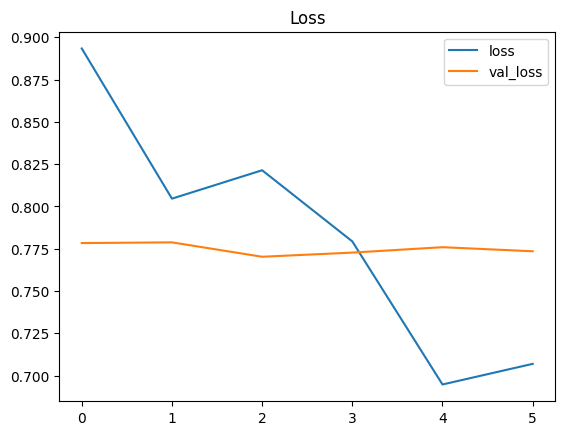

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot training history
history_df = pd.DataFrame(history.history)
plt.figure()
history_df.loc[:, ['loss', 'val_loss']].plot(title='Loss')
plt.savefig(os.path.join(model_save_dir, 'loss_plot.png'))
plt.figure()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')
plt.savefig(os.path.join(model_save_dir, 'accuracy_plot.png'))
plt.close()

In [18]:
# Evaluate on validation set
val_images, val_labels = [], []
for images, labels in val_ds.unbatch().take(-1):
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())
val_images = np.array(val_images)
val_labels = np.array(val_labels)
val_predictions = (model.predict(val_images) > 0.5).astype('int32')
print('Classification Report:')
print(classification_report(val_labels, val_predictions, target_names=['Cat', 'Dog']))
print('Confusion Matrix:')
print(confusion_matrix(val_labels, val_predictions))

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Classification Report:
              precision    recall  f1-score   support

         Cat       0.54      0.61      0.57        57
         Dog       0.52      0.44      0.48        54

    accuracy                           0.53       111
   macro avg       0.53      0.53      0.53       111
weighted avg       0.53      0.53      0.53       111

Confusion Matrix:
[[35 22]
 [30 24]]


In [19]:
# Prediction function with error handling
def predict_image(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize((64, 64))
        plt.imshow(img)
        plt.savefig(os.path.join(model_save_dir, 'prediction_image.png'))
        plt.close()
        img = np.array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        result = model.predict(img)
        print(f'Prediction: {"Dog" if result[0][0] >= 0.5 else "Cat"} (Confidence: {result[0][0]:.2f})')
    except Exception as e:
        print(f'Error processing image {image_path}: {e}')

In [20]:
# Test predictions
test_dir = output_dir
for class_name in ['Cat', 'Dog']:
    class_dir = os.path.join(test_dir, class_name)
    test_image = os.path.join(class_dir, os.listdir(class_dir)[0]) if os.listdir(class_dir) else None
    if test_image:
        predict_image(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
Prediction: Dog (Confidence: 0.58)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Prediction: Dog (Confidence: 0.52)
